# Predicting Game Success for Nintendo

#### Elliot Shabram, Alexander Ventura, Yulisa Ayala-Garcia
#### 4/27/2023



## Introduction

We have chosen to explore the Video Game Sales Dataset, a collection of price and ratings data scraped from VGChartz. Our question is whether we can produce a decent machine learning (ML) model for predicting prices of newly released Nintendo games to see whether they might be successful or not.

This dataset was obtained from this link on 05/04/2023:
https://www.kaggle.com/datasets/sidtwr/videogames-sales-dataset?select=PS4_GamesSales.csv

## Read the data

In [670]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, learning_curve
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'
warnings.filterwarnings("ignore", category=UserWarning)


df = pd.read_csv("vgsales.csv")

## Functions

In [671]:
def forward_selection_classif(clf, X, y, threshold=None, num_folds=5):
    """ Perform forward feature selection with the given classifier.
    Threshold is the improvement in accuracy for the selection
    process to stop.
    threshold = None causes all features to be selected.
    """

    remaining = list(range(X.shape[1]))
    selected = []
    accuracies = []
    previous_best = 0.0
    while len(remaining) > 0:
        best_i, best_accuracy = 0, 0.0
        for i in remaining:
            accuracy = cross_val_score(clf, X[:,selected+[i]], y, cv=num_folds).mean()
            if accuracy > best_accuracy:
                best_i, best_accuracy = i, accuracy

        if (threshold is not None) and (best_accuracy - previous_best) < threshold:
            break
        selected.append(best_i)
        accuracies.append(best_accuracy)
        if best_i in remaining:
          remaining.remove(best_i)
        previous_best = best_accuracy

    return np.array(selected), accuracies

Obtained from Dr.Bruns data-science-report-structure document

In [672]:
def print_conf_mtx(y_true, y_pred, classes=None):
    """ Print a confusion matrix (two classes only). """

    if not classes:
        classes = ['neg', 'pos']

    # formatting
    max_class_len = max([len(s) for s in classes])
    m = max(max_class_len, len('predicted')//2 + 1)
    n = max(len('actual')+1, max_class_len)
    left   	= '{:<10s}'.replace('10',str(n))
    right  	= '{:>10s}'.replace('10',str(m))
    big_center = '{:^20s}'.replace('20',str(m*2))

    cm = confusion_matrix(y_test, y_pred)
    print((left+big_center).format('', 'predicted'))
    print((left+right+right).format('actual', classes[0], classes[1]))
    print((left+right+right).format(classes[0], str(cm[0,0]), str(cm[0,1])))
    print((left+right+right).format(classes[1], str(cm[1,0]), str(cm[1,1])))

## Initial data exploration

Firtst we'll look at some basic information about the dataframe.

In [673]:
df.info()
print(f'\nShape of df: {df.shape}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       7590 non-null   float64
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(10), object(6)
memory usage: 2.0+ MB

Shape of 

The data set is reasonably big at 16719.

Let's take a look at some variable in the data set. We'll take a snapshot of the first 5 rows.

In [674]:
df.head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Nintendo dominates the first few rows, and we can also see that Nintendo is it's own developer in some cases. Publisher is probably pretty general, but the platform column looks like it will give us many options to draw connections from, so perhaps that will be a more important column in our ML model. Also, we can already see quite a few NaN values, so we'll want to look into that further.

We'd like to know how much of the data we can actually use. Lets take a look at some of the missing data to see if there is anything significant that may require dealing with. To see this, we'll print out the percentages of each column that are NaN values.

In [675]:
(df.isna().sum() / df.shape[0]).round(3)

Name               0.000
Platform           0.000
Year_of_Release    0.016
Genre              0.000
Publisher          0.003
NA_Sales           0.000
EU_Sales           0.000
JP_Sales           0.000
Other_Sales        0.000
Global_Sales       0.000
Critic_Score       0.513
Critic_Count       0.513
User_Score         0.546
User_Count         0.546
Developer          0.396
Rating             0.405
dtype: float64

It appears that some columns have around 50% missing data, which is not good. Critic's and user's scores wouldn't make sense to use for predicting sales a video game will make because scoring comes after a game has made sales and those numbers go hand in hand. For the developer and Rating columns,we'll have to replace the NaN values with  something so that we can utilize them.

Lets take a look at the developer category.

In [676]:
nintendo = (df['Developer'] == 'Nintendo').sum() / df['Developer'].shape[0]
print(f'Nintendo     {nintendo:.3g}\n')
print('Top 5:')
df['Developer'].value_counts(normalize=True).head().round(3)

Nintendo     0.00431

Top 5:


Ubisoft      0.020
EA Sports    0.017
EA Canada    0.017
Konami       0.016
Capcom       0.014
Name: Developer, dtype: float64

Interestingly, Nintendo is only it's own developer for a very small percentage of all games. Though it may sound similar to publisher at first, it seems quite different, thus it should be a good predictor for our ML model.

Since we want to predict success for Nintendo games, lets look at the median sales of a Nintendo game for any given year.

In [677]:
pub_sales = df.groupby('Publisher')['Global_Sales'].median()
med = pub_sales[pub_sales.index == 'Nintendo'].sum()
print(f'Median sales for Nintendo games: {med:.3g} million')

Median sales for Nintendo games: 0.89 million


It looks like right around 1 million dollars might be a good decision boundary for success for a company like Nintendo.

## Data cleaning and preprocessing

We'll drop the columns that would not be logical to use outright, and print the new columns as a sanity check.

In [678]:
df.drop(['Critic_Score', 'Critic_Count', 'User_Score', 'User_Count'], axis=1, inplace=True)
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Developer',
       'Rating'],
      dtype='object')

We'll then want to keep the rows that are Nintendo. From this point we can get rid of any remaining rows that contain NaN values. We'll also convert the years to integers now that there aren't any missing values. We will also change the name of Year_of_Release for simplicity and for columns that have many variables we'll group smaller ones into other categories.

In [679]:
# replace na values for columns with large amounts of NaN values
df['Rating'].fillna('NA', inplace=True)
df['Developer'].fillna('NA', inplace=True)

# change name and datatype for simplicity
df = df.rename(columns={'Year_of_Release': 'Year'})
df.dropna(inplace=True)
df['Year'] = df['Year'].astype(int)

# Make 'Other' categories to simplify variables
counts = df['Platform'].value_counts()
other = counts[counts < 100].index.tolist()
df['Platform'] = df['Platform'].replace(other, 'Other')

counts = df['Developer'].value_counts()
other = counts[counts < 40]. index.tolist()
df['Developer'].replace(other, 'Other', inplace=True)

# only look at Nintendo games
df = df[df['Publisher'] == 'Nintendo']

print(f'Total NaN values in DataFrame df: {df.isna().sum().sum()}')
print(f'\nNew shape of DataFrame df: {df.shape}')

Total NaN values in DataFrame df: 0

New shape of DataFrame df: (700, 12)


Success! There isn't a huge amount of data, but it should be sufficient.

## Exploration and visualization

We'd like to visualize global sales per year as well as counts for new releases.

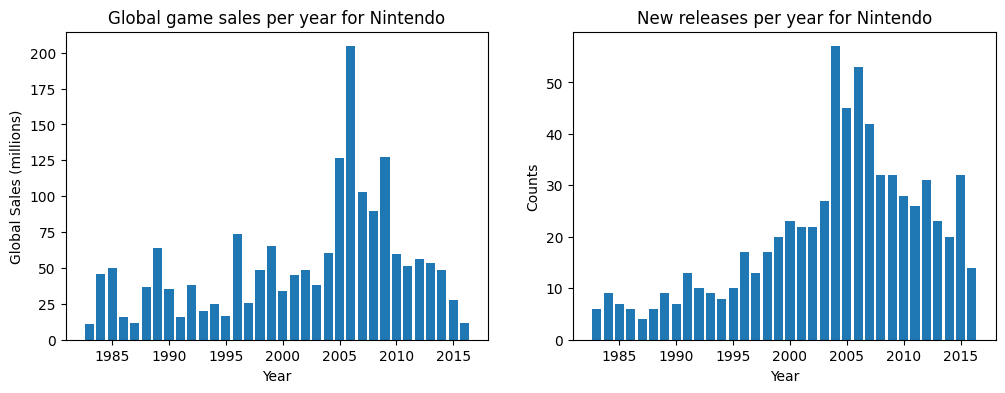

In [680]:
fig, (plt1, plt2) = plt.subplots(ncols=2, figsize=(12, 4))

sales = df.groupby('Year')['Global_Sales'].sum()
plt1.bar(x=sales.index, height=sales.values)
plt1.set_title('Global game sales per year for Nintendo')
plt1.set_xlabel('Year')
plt1.set_ylabel('Global Sales (millions)')

counts = df['Year'].value_counts().sort_index()
plt2.bar(x=counts.index, height=counts.values)
plt2.set_title('New releases per year for Nintendo')
plt2.set_xlabel('Year')
plt2.set_ylabel('Counts');

Nintendo appears to have been making quite a bit of money, peaking just before the 2008 finacial crisis, which probably explains the steep decline in profits after that point. The number of new releases corresponds with counts, but the general up and down trend may make it more difficult to predict sales, given the volitility and inconsistency of sales for any given year.

Next we will will look at the platform variable to see if we can find any patterns. Just like the previous plots, we'll compare the global sales per platform to the number of new releases per platform.

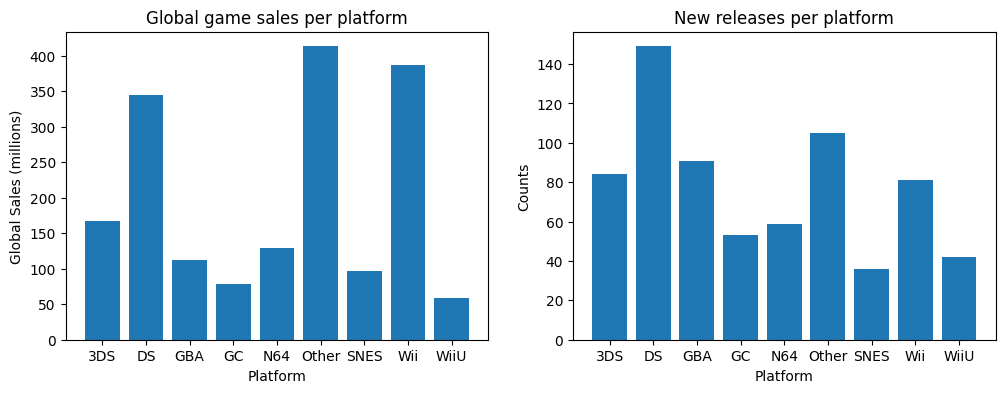

In [681]:
fig, (plt1, plt2) = plt.subplots(ncols=2, figsize=(12, 4))

sales = df.groupby('Platform')['Global_Sales'].sum()
plt1.bar(x=sales.index, height=sales.values)
plt1.set_title('Global game sales per platform')
plt1.set_xlabel('Platform')
plt1.set_ylabel('Global Sales (millions)')

counts = df['Platform'].value_counts().sort_index()
plt2.bar(x=counts.index, height=counts.values)
plt2.set_title('New releases per platform')
plt2.set_xlabel('Platform')
plt2.set_ylabel('Counts');

There isn't a clear pattern between how many games on a platform and how much money each platform is making relative to others, which may mean that platform doesn't have a clear pattern for the ML model to draw from.

Now we look at total sales per genre and rating to see which of the variable might help our model the most.

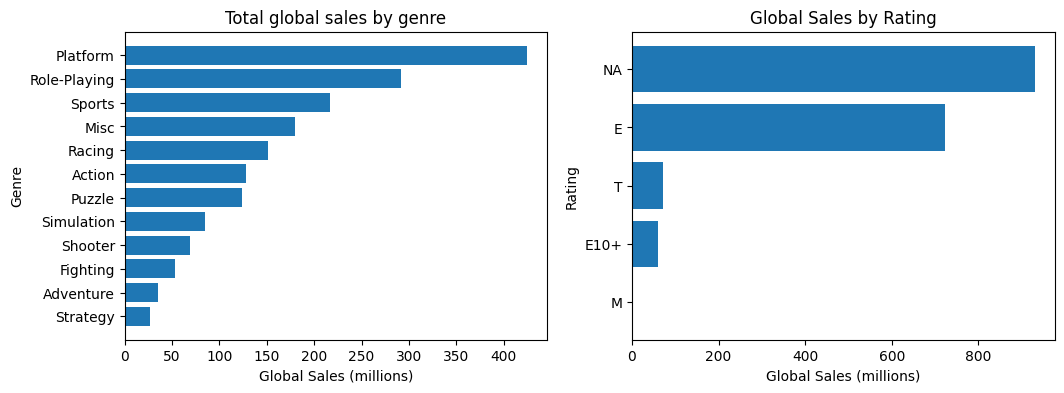

In [682]:
fig, (plt1, plt2) = plt.subplots(ncols=2, figsize=(12, 4))

genre = df.groupby('Genre')['Global_Sales'].sum().sort_values(ascending=True)
plt1.barh(y=genre.index, width=genre.values)
plt1.set_title('Total global sales by genre')
plt1.set_xlabel('Global Sales (millions)')
plt1.set_ylabel('Genre')

rate = df.groupby('Rating')['Global_Sales'].sum().sort_values(ascending=True)
plt2.barh(y=rate.index, width=rate.values)
plt2.set_title('Global Sales by Rating');
plt2.set_xlabel('Global Sales (millions)')
plt2.set_ylabel('Rating');

The Platform variable (different than the column) and the NA and E ratings are the leading variables for these two categories, and will likely add the most to our ML model.



## Data preparation for machine learning

Since our median value for global sales was around .9 million, we have chosen 1 million as our pivot point for whether a game is a success or not. We'll split the global sales into two different categorical variables for our target variable.

In [683]:
bins = [0.0, 1.0, 100.0]
labels = ['<1M', '>1M']
df['Global_Sales'] = pd.cut(df['Global_Sales'], bins=bins, labels=labels)

We'll now create dummy variables from the Genre, Platform, Rating, and Developer columns and assign their values to X. We will also select our target variable and run forward feature selection to find the best features. For our algorithm, we have chosen Logistic Regression, which works well for binary classifications, such as ours.

In [684]:
var_names = pd.get_dummies(df, columns=['Genre', 'Platform', 'Rating', 'Developer'], drop_first=True)
var_names.drop(['Name', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Year', 'Publisher'], axis=1, inplace=True)

df = pd.get_dummies(df, columns=['Genre', 'Platform', 'Rating', 'Developer'], drop_first=True)

predictors = list(var_names.columns.values)
target = 'Global_Sales'

X = df[predictors].values
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

clf = LogisticRegression(C=0.07, max_iter=1000, random_state=42)

selected, accuracies = forward_selection_classif(clf, X, y, 0.01)
print(f'Selected features: {selected}\n')
var_names.columns[selected]

Selected features: [15 26  3 12]



Index(['Platform_Other', 'Developer_Nintendo', 'Genre_Platform',
       'Platform_GBA'],
      dtype='object')

Our forward feature selection was successful in finding four features that will give our model a better chance of success. Four features is not ideal, but after much trial and error with feature engineering, this was the best we could achieve. In general, the data doesn't seem to correlate well with global sales, which is why we changed our target variable to a categorical one. We do see that Genre_Platform and Platform_Other are two of our features, which might seem an obvious choice given that they were the largest sales variables of their respective columns, but then why pick Platform_GBA and Developer_Nintendo? Clearly, there are deeper connections that are difficult to see.

## Machine learning

Now lets train our model with the selected features and the training data.



In [685]:
clf.fit(X_train[:, selected], y_train);

Success.

Let's check if our model has a high bias or high variance problem.

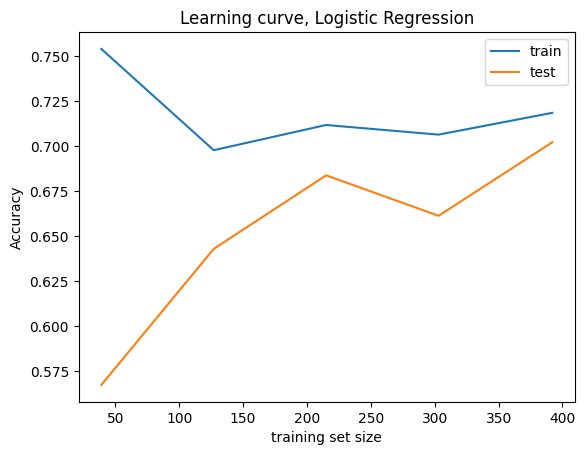

In [686]:
train_sizes, train_scores, test_scores = \
learning_curve(clf, X_train, y_train, cv=5,scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.plot(train_sizes, train_scores_mean, label='train')
plt.plot(train_sizes, test_scores_mean, label='test')
plt.xlabel('training set size')
plt.ylabel('Accuracy')
plt.title('Learning curve, Logistic Regression')
plt.legend();

After some more trial and error adjusting the parameters of our classifier, we're satisfied with this learning curve. There is a somewhat large gap between our training and test accuracies, implying a high variance situation. Clearly more data would help us here, but the fit seems to be near optimal for what we have.

Now lets score our models performance by comparing an accuracy score to a baseline. We'll also throw in a cross validation score to estimate our models performance on independent data, and to use as a check on our other scores.


In [687]:
baseline = (df['Global_Sales'] == '<1M').sum() / df['Global_Sales'].shape[0]
print(f'Baseline Accuracy: {baseline:.2g}\n')

score = cross_val_score(clf, X, y, cv=5 ).mean()

y_pred = clf.predict(X_test[:, selected])

accuracy = accuracy_score(y_test, y_pred)

print(f'Cross Validation Score: {score:.3g}\n')
print(f'Accuracy: {accuracy:.3g}')

Baseline Accuracy: 0.52

Cross Validation Score: 0.664

Accuracy: 0.643


It appears that our model has improved upon the baseline accuracy by about 12%. That is a very reasonable improvment over simply guessing, and it would seem that our model is successful.

Lets see the predictions and the actual values side by side with a confusion matrix as a final, more tangible check on our model.

In [688]:
print_conf_mtx(y_test, y_pred)

       predicted 
actual   neg  pos
neg       76   21
pos       54   59


Here we can calculate by hand the correctly predicted negatives and positives, and divide those by the total predictions, and we see that our accuracy is the same here, verifying our model's accuracy once again.



## Conclusions

Overall, the data was difficult to extract connections from. We saw that global sales changed year to year, and that there weren't many clear connections between variables, which caused us to narrow our target to something reasonable given the limited correlation. We chose a reasonable metric for a successful game based on the median, and our predictions improved upon the baseline by over 12%. This is a good improvement. Given more time, and given what we have learned in the process of refining our ML model, we are sure that improvements could be made by continued and more complex feature engineering and perhaps some anomoly detection. We learned that game sales are volatile and sensative to change, making them hard to predict. We think this kind of model could be useful in flagging bad video games, and could conceivably be applied to other big companies, and even other products.